In [146]:
# Importa a gdal
from osgeo import gdal, ogr, osr
gdal.UseExceptions()
from gdalconst import *
# Importa o matplotlib
import matplotlib.pyplot as plt
# Importa o Numpy
import numpy as np
import math
import xml.etree.ElementTree as ET
import os
import fiona
from shapely.geometry import shape, mapping

# Carrega a máscara de nuvens

In [155]:
# Abre a mascara de nuvem gerada anteriormente
nome_arquivo_mascara_nuvens = '../imagens/mascara_nuvens_CBERS_20180131.tif'

print ("Abrindo o arquivo: " + nome_arquivo_mascara_nuvens)

# Tenta abrir a imagem
try:
    mascara_nuvens = gdal.Open(nome_arquivo_mascara_nuvens, GA_ReadOnly)
    print("Arquivo aberto com sucesso!")
except:
    print("Erro na abertura do arquivo!")

Abrindo o arquivo: ../imagens/mascara_nuvens_CBERS_20180131.tif
Arquivo aberto com sucesso!


In [148]:
# Obtém a banda única do dataset
banda_mascara = mascara_nuvens.GetRasterBand(1)
# Transforma a banda em array
array_banda_mascara = banda_mascara.ReadAsArray()

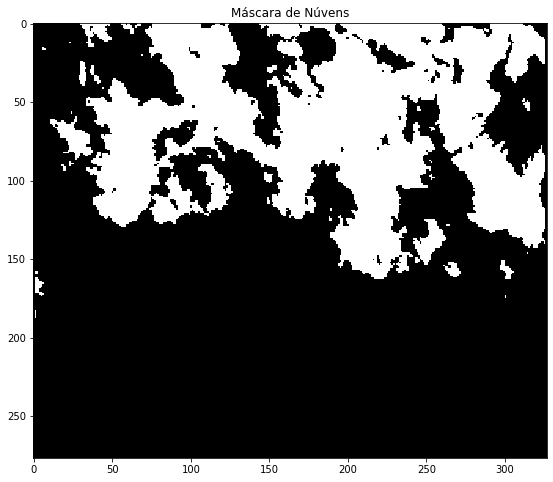

In [149]:
# Cria a figura
plt.figure(figsize = (16, 8))

# Mostra a máscara de nuvens
plt.title("Máscara de Núvens")
plt.imshow(array_banda_mascara, cmap='gray');

# Gera a máscara de sombras inicial (vetorização da máscara de nuvens)

Aqui foi feita a vetorização da máscara de nuvens proveniente do outro notebook. A falta de compatibilidade entre as cenas é pq não tem um src atrelado à mascara ainda, a Grazi já ajeitou isso no git dela. Vamos atualizar assim que decidimos os commit kk

In [150]:
## EPSG = int(osr.SpatialReference(wkt=mascara_nuvens.GetProjection()).GetAttrValue('AUTHORITY',1))
srs = osr.SpatialReference()
srs.ImportFromWkt(mascara_nuvens.GetProjectionRef())
# srs.ImportFromEPSG(EPSG)

shp_layername = '../shp/mascara_sombra_inicial'
driver = ogr.GetDriverByName("ESRI Shapefile")   
shp_datasource = driver.CreateDataSource(shp_layername + '.shp')
shp_layer = shp_datasource.CreateLayer(shp_layername, srs=srs)

new_field = ogr.FieldDefn('DN', ogr.OFTReal)
shp_layer.CreateField(new_field) 


gdal.Polygonize(banda_mascara, banda_mascara, shp_layer, 0, [], callback=None)

shp_datasource.Destroy()

# Deslocamento da máscara de nuvens a partir de um delta_x e delta_y calculado pelas informações dos metadados

## Cálculo do Delta

In [151]:
tree = ET.parse('../imagens/CBERS_4_MUX_20180131_172_139_L2/20180131_BAND8/20180131_BAND8.xml')
root = tree.getroot()

image = root.find("{http://www.gisplan.com.br/xmlsat}image")
sun_incidence = root.find("{http://www.gisplan.com.br/xmlsat}sunIncidenceAngle")
degree_sun_incidence = int(sun_incidence.find('{http://www.gisplan.com.br/xmlsat}degree').text)
minute_sun_incidence = int(sun_incidence.find('{http://www.gisplan.com.br/xmlsat}minute').text)
second_sun_incidence = int(sun_incidence.find('{http://www.gisplan.com.br/xmlsat}second').text)

sun_incidence = degree_sun_incidence + minute_sun_incidence/60 + second_sun_incidence/3600

sun_position = image.find('{http://www.gisplan.com.br/xmlsat}sunPosition')
sun_azim = float(sun_position.find('{http://www.gisplan.com.br/xmlsat}sunAzimuth').text)
sun_zenith = float(sunposition.find('{http://www.gisplan.com.br/xmlsat}elevation').text)

sun_azim = math.radians(sun_azim)
sun_zenith = math.radians(sun_zenith)
view_azim = math.radians(0)
view_zenith = math.radians(0)

sen_sun_azi = math.sin(sun_azim)
cos_sun_azi = math.cos(sun_azim)
sen_view_azi = math.sin(view_azim)
cos_view_azi = math.cos(view_azim)
tan_sun_zenith = math.tan(sun_zenith)
tan_view_zenith = math.tan(view_zenith)

shadow_direction = math.pi + math.atan(sen_sun_azi*tan_sun_zenith-sen_view_azi*tan_view_zenith/
                                       (cos_sun_azi*tan_sun_zenith-cos_view_azi*tan_view_zenith))

h = 5000 # Altura das nuvens

shadow_distance = h * math.tan(math.radians(sun_incidence))

# shadow_distance2 = h * math.sqrt(
#     ( (sen_sun_azi*tan_sun_zenith) - (sen_view_azi*tan_view_zenith) )**2 +
#     ( (cos_sun_azi*tan_sun_zenith) - (cos_view_azi*tan_view_zenith) )**2
#     )

delta = (shadow_distance*math.cos(shadow_direction), shadow_distance*math.sin(shadow_direction))

## Deslocamento da máscara

In [153]:
# Essas três funções realizam o deslocamento das feições da camada. (Elas são recursivas entre si)
def movePoint_Coords(coords, delta):     # "delta" é uma tupla (delta_x, delta_y)
    return tuple(c + d for c, d in zip(coords, delta))
def moveLine_Coords(coords, delta):
    return list(movePoint_Coords(pt_coords, delta) for pt_coords in coords)
def movePolygon_Coords(coords, delta):
    return list(moveLine_Coords(ring_coords, delta) for ring_coords in coords)

with fiona.open('../shp/mascara_sombra_inicial.shp', "r") as shadow_cloud:

    with fiona.open("../shp/mascara_sombra_deslocada.shp", 
                    "w",
                    driver=shadow_cloud.driver,
                    schema=shadow_cloud.schema,
                    crs=shadow_cloud.crs) as moved_shadow:
        
        # Deslocamento de todas as feições da camada de máscara de nuvens vetorizada
        for feature in shadow_cloud:
            try:
                feature['geometry']['coordinates'] = shiftCoords_Polygon(feature['geometry']['coordinates'], delta)
                moved_shadow.write(feature)
            except:
                print("Error processing record %s:", feature)
            

# Subtração da mascara deslocada pela mascara de nuvens 

Onde é nuvem não é sombra, então será removida a interseção entre as duas camadas. Assim, permanece na mascara exclusivamente o que é sombra

In [154]:
with fiona.open('../shp/mascara_sombra_inicial.shp', "r") as shadow_cloud:
    with fiona.open("../shp/mascara_sombra_deslocada.shp", "r") as moved_shadow:
        
        with fiona.open("../shp/mascara_sombra_final.shp", 
                    "w",
                    driver=shadow_cloud.driver,
                    schema=shadow_cloud.schema,
                    crs=shadow_cloud.crs) as dif:
            
            for i, j in zip(moved_shadow,shadow_cloud):
                
                # Corrigir erros topológico que impedem a subtração dos poligonos                
                polygons_source = shape(j['geometry'])
                polygons_shift = shape(i['geometry'])
                
                polygons_source_correct = polygons_source.buffer(0)
                polygons_shift_correct = polygons_shift.buffer(0)
                
                j['geometry'] = mapping(polygons_source_correct)
                i['geometry'] = mapping(polygons_shift_correct)
                #################################################################
            
                try:
                    difference = shape(i['geometry']).difference(shape(j['geometry']))
                    i['geometry'] = mapping(difference)
                    dif.write(i)
                except:
                    print("Error processing record %s:", i)

# Apagar arquivos shapefile auxiliares
driver.DeleteDataSource('../shp/mascara_sombra_deslocada.shp')
driver.DeleteDataSource('../shp/mascara_sombra_inicial.shp');